# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install imageio pillow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import datetime
import os
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
project_folder='/datasets/Project_data'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
"""train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 15 #experiment with the batch size"""

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [49]:
# Define the ModelBuilder class with an abstract base class (ABCMeta) to enforce the definition of certain methods in derived classes
class ModelBuilder(metaclass=abc.ABCMeta):
    
    # Method to initialize the paths for training and validation data
    def initialize_path(self, project_folder):
        # Read and randomly shuffle the training and validation data file lines
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        
        # Define the paths for training and validation data
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        
        # Store the number of training and validation sequences
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # Method to initialize image properties such as dimensions and channels
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3  # RGB channels
        self.num_classes = 5  # Number of output classes
        self.total_frames = 30  # Total frames in each video
        
    # Method to initialize hyperparameters for training
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample  # Number of frames to sample from a video
        self.batch_size = batch_size  # Size of batches during training
        self.num_epochs = num_epochs  # Number of epochs for training
        
    # Generator function to yield batches of data and labels for training/validation
    def generator(self, source_path, folder_list, augment=False):
        # Generate a list of frame indices to sample
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        
        while True:
            # Randomly shuffle the folder list
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size  # Number of full batches
            
            # Generate data for each batch
            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            # Handle the remaining sequences if any (not forming a full batch)
            remaining_seq = len(t) % batch_size
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    # Method to process one batch of data
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        # Determine the sequence length for the current batch
        seq_len = remaining_seq if remaining_seq else batch_size
        
        # Initialize arrays for batch data and labels
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))
        
        if augment: 
            # Initialize array for augmented batch data
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        # Process each folder (video) in the batch
        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx): 
                # Read and resize the image
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                #image_resized = imresize(image, (self.image_height, self.image_width, 3))
                image_resized = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_AREA)
                
                
                # Normalize and add the image data to the batch
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
                
                if augment:
                    # Apply random transformations for augmentation
                    shifted = cv2.warpAffine(
                        image, 
                        np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                        (image.shape[1], image.shape[0])
                    )
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]
                    #image_resized = imresize(cropped, (self.image_height, self.image_width, 3))
                    image_resized = cv2.resize(cropped, (self.image_width, self.image_height), interpolation=cv2.INTER_AREA)
                    
                    # Normalize and add the augmented image data
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
            
            # Assign one-hot encoded labels to the batch
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
        
        if augment:
            # Concatenate original and augmented data/labels
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels
    
    # Method to train the model Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    def train_model(self, model, augment_data=False):
        # Create data generators for training and validation
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        # Generate a unique name for the model based on the current timestamp
        model_name = 'model_init_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Define the file path format for saving model checkpoints
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        # Define callbacks for saving checkpoints and reducing learning rate
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]
        
        # Calculate steps per epoch and validation steps
        steps_per_epoch = (self.num_train_sequences // self.batch_size) + (1 if self.num_train_sequences % self.batch_size != 0 else 0)
        validation_steps = (self.num_val_sequences // self.batch_size) + (1 if self.num_val_sequences % self.batch_size != 0 else 0)
        
        # Train the model using the data generators
        history = model.fit(
            train_generator, 
            steps_per_epoch=steps_per_epoch, 
            epochs=self.num_epochs, 
            verbose=1, 
            callbacks=callbacks_list, 
            validation_data=val_generator, 
            validation_steps=validation_steps, 
            class_weight=None, 
            workers=1, 
            initial_epoch=0
        )
        return history

    # Abstract method to define the model (must be implemented in subclasses)
    @abc.abstractmethod
    def define_model(self):
        pass


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
"""curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)"""

"curr_dt_time = datetime.datetime.now()\ntrain_path = '/datasets/Project_data/train'\nval_path = '/datasets/Project_data/val'\nnum_train_sequences = len(train_doc)\nprint('# training sequences =', num_train_sequences)\nnum_val_sequences = len(val_doc)\nprint('# validation sequences =', num_val_sequences)\nnum_epochs = 5 # choose the number of epochs\nprint ('# epochs =', num_epochs)"

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers.recurrent import LSTM
from keras.applications import mobilenet


## Model 1 - No Data Augmentation 160*160 image and (3,3,3) filter frame_to_sample 20 and batch size 40

In [9]:
class Conv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=256,dropout=0.5):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
conv_3d1_builder=Conv3D1()
conv_3d1_builder.initialize_path(project_folder)
conv_3d1_builder.initialize_image_properties(image_height=160,image_width=160)
conv_3d1_builder.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1_builder.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1_builder.train_model(conv_3d1_model)

Total Params: 3638981
Epoch 1/15


2024-12-29 10:09:54.436692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.7782 - categorical_accuracy: 0.3665
Epoch 00001: saving model to model_init_2024-12-2910_09_48.242857/model-00001-1.77817-0.36652-3.99287-0.23000.h5
17/17 [==============================] - 69s 4s/step - loss: 1.7782 - categorical_accuracy: 0.3665 - val_loss: 3.9929 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.5875 - categorical_accuracy: 0.4630
Epoch 00002: saving model to model_init_2024-12-2910_09_48.242857/model-00002-1.58754-0.46305-2.46896-0.19000.h5
17/17 [==============================] - 52s 3s/step - loss: 1.5875 - categorical_accuracy: 0.4630 - val_loss: 2.4690 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.2158 - categorical_accuracy: 0.6063
Epoch 00003: saving model to model_init_2024-12-2910_09_48.242857/model-00003-1.21581-0.60633-4.40816-0.21000.h5
17/17 [===============

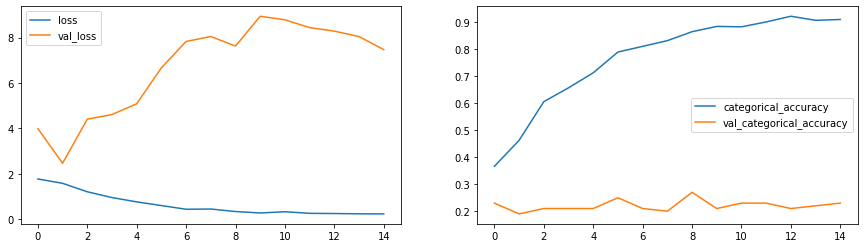

In [15]:
plot(history_model1)

## Model is Clearly overfitting hence we need to do data augmentation.

## Model 2 - Augment Data 160*160 image and (3,3,3) filter

In [21]:
conv_3d2_builder=Conv3D1()
conv_3d2_builder.initialize_path(project_folder)
conv_3d2_builder.initialize_image_properties(image_height=160,image_width=160)
conv_3d2_builder.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2_builder.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [22]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2_builder.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9045 - categorical_accuracy: 0.3929
Epoch 00001: saving model to model_init_2024-12-2717_12_50.333449/model-00001-1.90448-0.39291-2.75644-0.16000.h5
34/34 [==============================] - 102s 3s/step - loss: 1.9045 - categorical_accuracy: 0.3929 - val_loss: 2.7564 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4393 - categorical_accuracy: 0.5090
Epoch 00002: saving model to model_init_2024-12-2717_12_50.333449/model-00002-1.43934-0.50905-4.98472-0.25000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.4393 - categorical_accuracy: 0.5090 - val_loss: 4.9847 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2009 - categorical_accuracy: 0.5754
Epoch 00003: saving model to model_init_2024-12-2717_12_50.333449/model-00003-1.20090-0.57541-5.20118

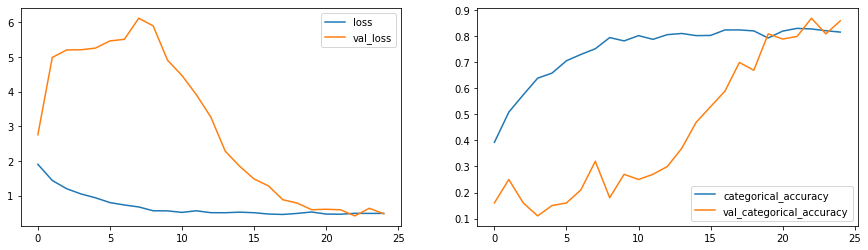

In [23]:
plot(history_model2)

### We have got 87% valdation accuracy and 82.88% train accuracy.Let see if we can increase the accuracy by adding more layer. Reducing the dense neuron to reduce model parameter.

## Model 3 - Augment Data 160*160 image and (3,3,3) filter with additional layer

In [50]:
class Conv3D2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.5):

        model = Sequential()
        model.add(Conv3D(8, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
             
     
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [51]:
conv_3d3_builder_e=Conv3D2()
conv_3d3_builder_e.initialize_path(project_folder)
conv_3d3_builder_e.initialize_image_properties(image_height=160,image_width=160)
conv_3d3_builder_e.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d3_model_e=conv_3d3_builder_e.define_model(dense_neurons=128,dropout=0.5)
conv_3d3_model_e.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_106 (Conv3D)         (None, 20, 160, 160, 8)   656       
                                                                 
 activation_106 (Activation)  (None, 20, 160, 160, 8)  0         
                                                                 
 batch_normalization_128 (Ba  (None, 20, 160, 160, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_106 (MaxPooli  (None, 20, 80, 80, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_107 (Conv3D)         (None, 20, 80, 80, 16)    3472      
                                                                 
 activation_107 (Activation)  (None, 20, 80, 80, 16) 

In [54]:
print("Total Params:", conv_3d3_model_e.count_params())
history_model3_e=conv_3d3_builder_e.train_model(conv_3d3_model_e,augment_data=True)

Total Params: 1133157
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8864 - categorical_accuracy: 0.3710
Epoch 00001: val_loss improved from inf to 2.68309, saving model to model_init_2024-12-2911_46_05.972006/model-00001-1.88643-0.37104-2.68309-0.21000.h5
34/34 [==============================] - 100s 3s/step - loss: 1.8864 - categorical_accuracy: 0.3710 - val_loss: 2.6831 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5533 - categorical_accuracy: 0.4487
Epoch 00002: val_loss did not improve from 2.68309
34/34 [==============================] - 97s 3s/step - loss: 1.5533 - categorical_accuracy: 0.4487 - val_loss: 4.9384 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4144 - categorical_accuracy: 0.4774
Epoch 00003: val_loss did not improve from 2.68309
34/34 [==============================] - 97s 3s/step - loss: 1.4144 - cat

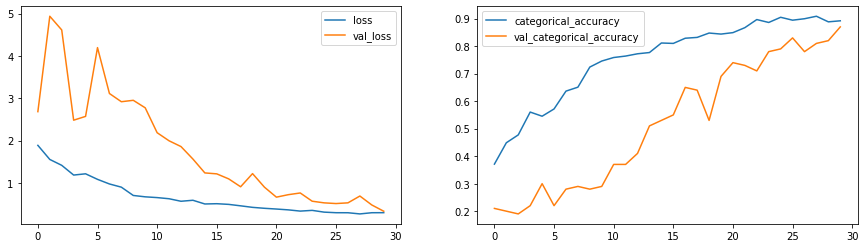

In [55]:
plot(history_model3_e)

#### We have got 87% valdation accuracy and 89.22% train accuracy with 1/3 number of Parameters compared to previous model 2.Let see if we can increase the accuracy by using CNN and LSTM . 
- Used batch Normalization as network has multiple layers. 
- Dropout used to prevent overfitting.
- Model3 file : model_init_2024-12-2911_46_05.972006/model-00030-0.29491-0.89216-0.32904-0.87000.h5
 

## Model4 - CNN- RNN(LSTM) Model

### We have received good vlidation score so far and Like to try further with CNN + LSTM to see if we can achive better accuracy. Reduce Dense layer Neuron to 128

In [10]:
class RNNCNNMODEL(ModelBuilder):
    
    def define_model(self,filtersize=(3,3),lstm_cells=64,dense_neurons=256,dropout=0.5):

        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, filtersize, padding='same',activation='relu'),
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
              
        model.add(TimeDistributed(Conv2D(16, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    

In [16]:
rnn_cnn1=RNNCNNMODEL()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn1.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=30)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 20, 160, 160, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 160, 160, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 80, 80, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 80, 80, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 20, 80, 80, 16)  

In [17]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model4=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1820981
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6225 - categorical_accuracy: 0.2768
Epoch 00001: saving model to model_init_2024-12-2813_51_56.347215/model-00001-1.62249-0.27677-1.68186-0.17000.h5
67/67 [==============================] - 137s 2s/step - loss: 1.6225 - categorical_accuracy: 0.2768 - val_loss: 1.6819 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.4273 - categorical_accuracy: 0.3695
Epoch 00002: saving model to model_init_2024-12-2813_51_56.347215/model-00002-1.42726-0.36953-2.01062-0.14000.h5
67/67 [==============================] - 132s 2s/step - loss: 1.4273 - categorical_accuracy: 0.3695 - val_loss: 2.0106 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.3676 - categorical_accuracy: 0.4027
Epoch 00003: saving model to model_init_2024-12-2813_51_56.347215/model-00003-1.36760-0.40271-1.8091

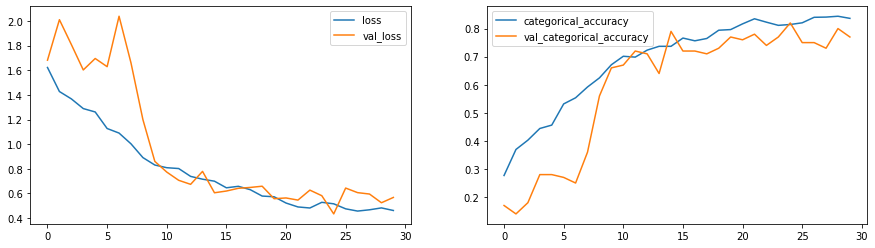

In [18]:
plot(history_model4)

####  With LSTM coudnt see any improvement in accuracy score hency trying using GRU to achive good accuracy with less computation time and less number of parameters.

### Model5 - CNN- RNN (GRU) Model

In [11]:
class RNNCNNMODELGRU(ModelBuilder):
    
    def define_model(self,filtersize=(3,3),gru_cells=64,dense_neurons=256,dropout=0.5):

        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, filtersize, padding='same',activation='relu'),
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
              
        model.add(TimeDistributed(Conv2D(16, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, filtersize, padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
rnn_cnn_gru_builder=RNNCNNMODELGRU()
rnn_cnn_gru_builder.initialize_path(project_folder)
rnn_cnn_gru_builder.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn_gru_builder.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=30)
rnn_cnn_gru_model=rnn_cnn_gru_builder.define_model(gru_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 160, 160, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 160, 160, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 80, 80, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 80, 80, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 80, 80, 16)  

In [12]:
print("Total Params:", rnn_cnn_gru_model.count_params())
history_model5=rnn_cnn_gru_builder.train_model(rnn_cnn_gru_model,augment_data=True)

Total Params: 1395253
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6650 - categorical_accuracy: 0.3167
Epoch 00001: saving model to model_init_2024-12-2812_43_48.202386/model-00001-1.66500-0.31674-2.91684-0.21000.h5
67/67 [==============================] - 136s 2s/step - loss: 1.6650 - categorical_accuracy: 0.3167 - val_loss: 2.9168 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3736 - categorical_accuracy: 0.4080
Epoch 00002: saving model to model_init_2024-12-2812_43_48.202386/model-00002-1.37358-0.40799-2.61916-0.13000.h5
67/67 [==============================] - 141s 2s/step - loss: 1.3736 - categorical_accuracy: 0.4080 - val_loss: 2.6192 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.2715 - categorical_accuracy: 0.4374
Epoch 00003: saving model to model_init_2024-12-2812_43_48.202386/model-00003-1.27146-0.43741-3.0438

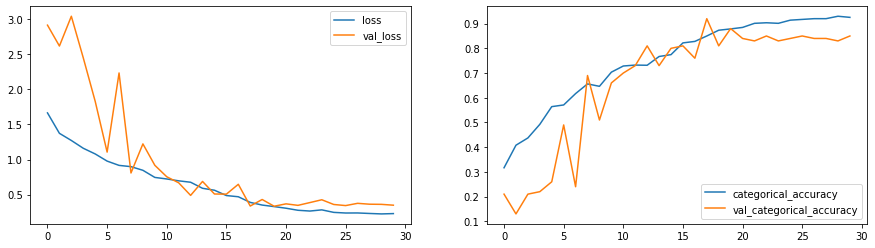

In [13]:
plot(history_model5)

### Model6 - Transfer learning Mobilenet - LSTM (GRU) Model

#### Using Mobilenet as model is small Fast best suitable for Edge devices, real-time recognition 

In [57]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNNMODELMOBILENETGRU(ModelBuilder):
      
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.5):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [58]:
rnn_cnn_mobilenet_gru_builder=RNNCNNMODELMOBILENETGRU()
rnn_cnn_mobilenet_gru_builder.initialize_path(project_folder)
rnn_cnn_mobilenet_gru_builder.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn_mobilenet_gru_builder.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=30)
rnn_cnn_moblenet_gru_model=rnn_cnn_mobilenet_gru_builder.define_model(gru_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn_moblenet_gru_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 5, 5, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 5, 5, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 2, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 4096)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)             

In [60]:
print("Total Params:", rnn_cnn_moblenet_gru_model.count_params())
history_model6=rnn_cnn_mobilenet_gru_builder.train_model(rnn_cnn_moblenet_gru_model,augment_data=True)

Total Params: 4872901
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.2858 - categorical_accuracy: 0.4653
Epoch 00001: val_loss improved from inf to 0.89897, saving model to model_init_2024-12-2912_44_35.947285/model-00001-1.28579-0.46531-0.89897-0.62000.h5
67/67 [==============================] - 107s 2s/step - loss: 1.2858 - categorical_accuracy: 0.4653 - val_loss: 0.8990 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.7002 - categorical_accuracy: 0.7202
Epoch 00002: val_loss improved from 0.89897 to 0.59170, saving model to model_init_2024-12-2912_44_35.947285/model-00002-0.70017-0.72021-0.59170-0.75000.h5
67/67 [==============================] - 103s 2s/step - loss: 0.7002 - categorical_accuracy: 0.7202 - val_loss: 0.5917 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.5003 - categorical_accuracy: 0.8107
Epoch 00003: val_l

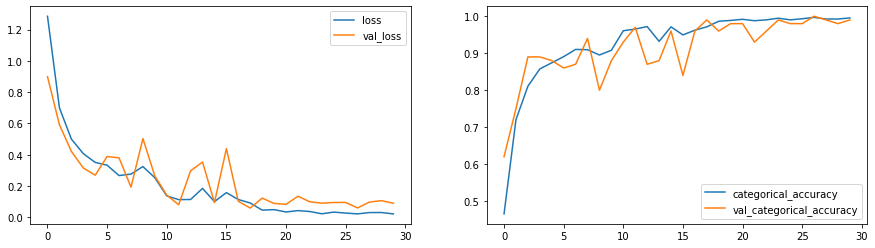

In [62]:
plot(history_model6)

#### With Transfer learning and Mobilenet we have achived significantly higher validation 99% and Test accuracy 97.13% . 

At Epoch 00018  val_loss improved to 0.05865, hence saved model to model_init_2024-12-2912_44_35.947285/model-00018-0.09115-0.97134-0.05865-0.99000.h5

However moder parameters count is on the high 4872901

### Loading model and Testing

In [63]:
import time
from keras.models import load_model
model3 = load_model('model_init_2024-12-2911_46_05.972006/model-00030-0.29491-0.89216-0.32904-0.87000.h5')
model6 = load_model('model_init_2024-12-2912_44_35.947285/model-00018-0.09115-0.97134-0.05865-0.99000.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [64]:
test_generator=Conv3D2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [65]:
batch_data.shape

(20, 20, 160, 160, 3)

In [66]:
batch_labels.shape

(20, 5)

## Model 3:
### prediction using model 3 which is a Conv3d based model with : valdation accuracy 87%  , train accuracy: 89.22% , Total Params: 1133157
- File Name :  model_init_2024-12-2911_46_05.972006/model-00030-0.29491-0.89216-0.32904-0.87000.h5

Video 0 for Gesture: swipe-right/forward-10-sec: Predicted Gesture: swipe-right/forward-10-sec, Confidence: 0.80


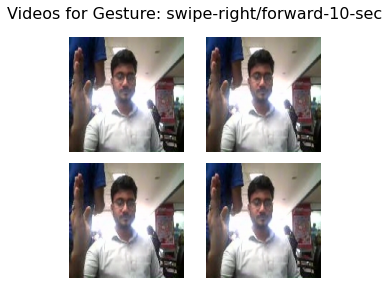

Video 1 for Gesture: swipe-left/backward-10-sec: Predicted Gesture: swipe-left/backward-10-sec, Confidence: 1.00


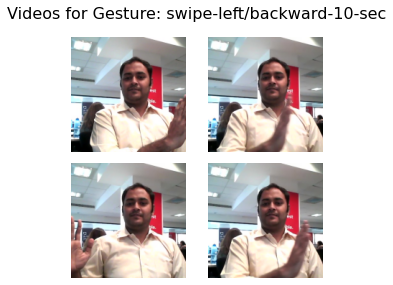

Video 2 for Gesture: Palm/pause: Predicted Gesture: swipe-right/forward-10-sec, Confidence: 0.54


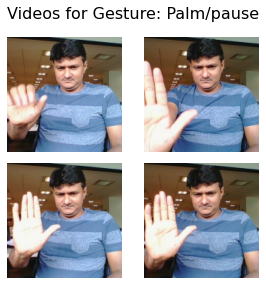

Video 3 for Gesture: Thumbs-down/lower-the-volume: Predicted Gesture: Thumbs-down/lower-the-volume, Confidence: 1.00


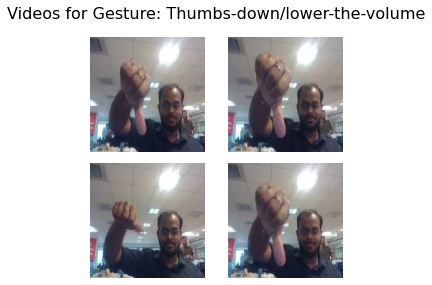

Video 4 for Gesture: thumbs-up/Higher-the-volume: Predicted Gesture: thumbs-up/Higher-the-volume, Confidence: 0.65


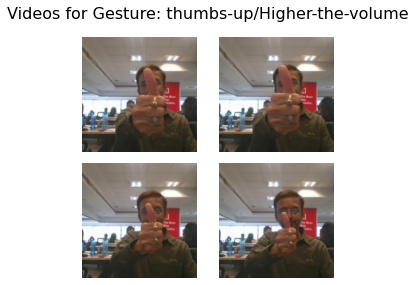

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary mapping class indices to gesture names
class_mapping = {
    0: "swipe-right/forward-10-sec",
    1: "swipe-left/backward-10-sec",
    2: "Palm/pause",
    3: "Thumbs-down/lower-the-volume",
    4: "thumbs-up/Higher-the-volume",
}

# Grid settings
grid_columns, grid_rows = 2, 2
videos_per_class = {i: [] for i in range(len(class_mapping))}

# Group videos by their true labels
for i in range(batch_data.shape[0]):
    video = batch_data[i]
    true_label_index = np.argmax(batch_labels[i])  # Ground truth label index
    videos_per_class[true_label_index].append(video)

# Plot a grid of videos per class and make predictions
for class_idx, videos in videos_per_class.items():
    gesture_name = class_mapping.get(class_idx, "Unknown Gesture")
    
    # Create the figure for the grid of videos
    plt.figure(figsize=(4, 4))
    plt.suptitle(f"Videos for Gesture: {gesture_name}", fontsize=16)

    # Plot videos and frames for the current class
    for idx, video in enumerate(videos[:grid_columns * grid_rows]):  # Limit to grid size
        for frame_idx, frame in enumerate(video[:grid_columns * grid_rows]):
            plot_position = idx * grid_columns * grid_rows + frame_idx + 1
            if plot_position <= grid_rows * grid_columns:
                plt.subplot(grid_rows, grid_columns, plot_position)
                plt.imshow((frame * 255).astype('uint8'))  # Rescale to [0, 255]
                plt.axis('off')

        # Get model prediction for the current video
                prediction = model3.predict(np.expand_dims(video, axis=0))  # Predict for the current video
                predicted_class = np.argmax(prediction, axis=1)[0]
                confidence = prediction[0][predicted_class]  # Get the confidence for the prediction

        # Print the predicted class name for the video
    predicted_label_name = class_mapping.get(predicted_class, "Unknown Gesture")  # Predicted class name
    print(f"Video {class_idx } for Gesture: {gesture_name}: Predicted Gesture: {predicted_label_name}, Confidence: {confidence:.2f}")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_204/1126753797.py:31: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(video_indices, predicted_labels_numeric, c='red', label='Predicted Labels', alpha=0.7, marker='x', edgecolors='w', s=200)


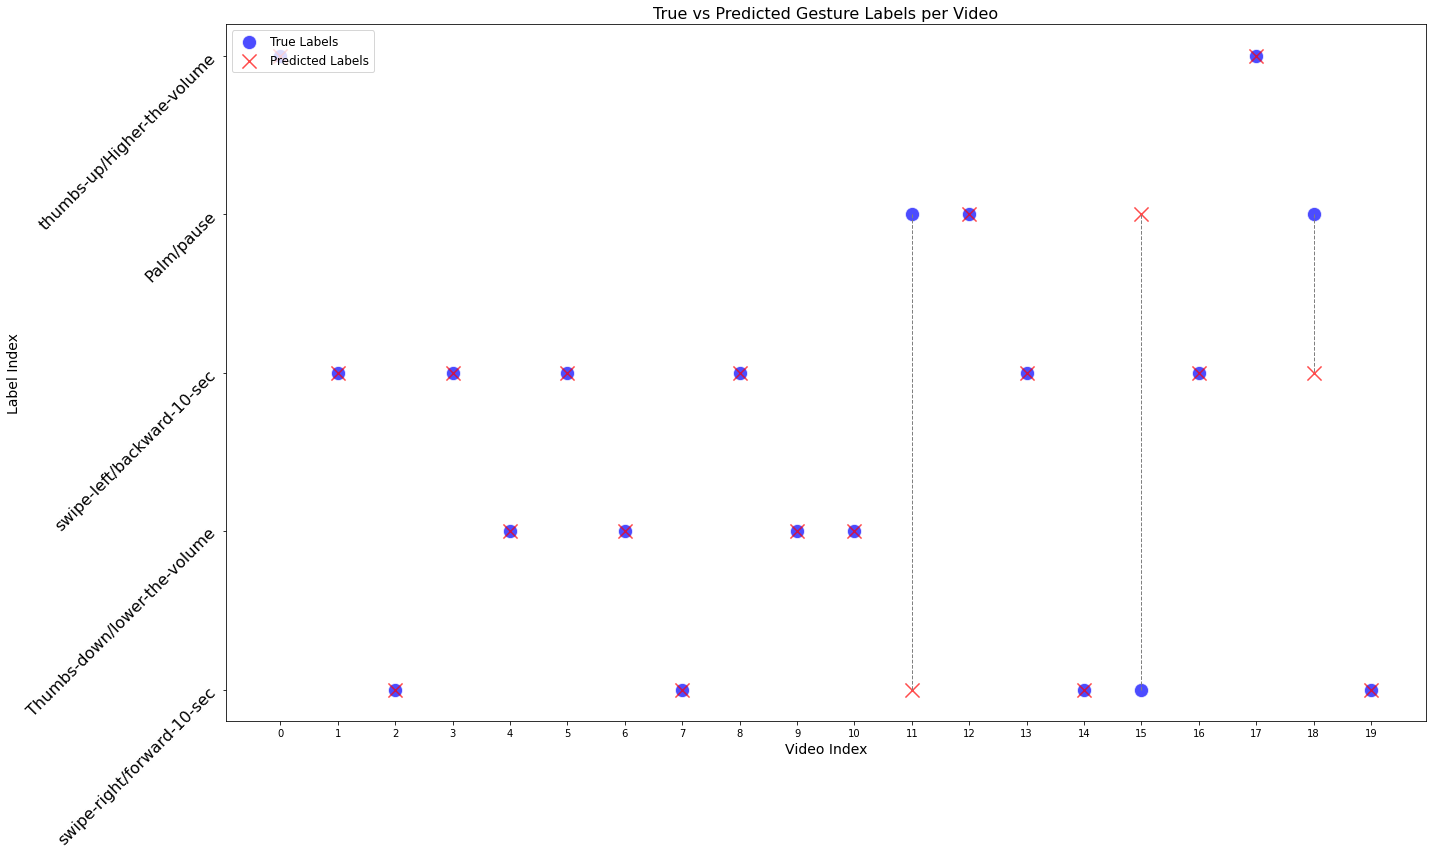

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary mapping class indices to gesture names
class_mapping = {
    0: "swipe-right/forward-10-sec", 1: "swipe-left/backward-10-sec", 
    2: "Palm/pause", 3: "Thumbs-down/lower-the-volume", 4: "thumbs-up/Higher-the-volume",
}

# Initialize lists for statistics
true_labels_list, predicted_labels_list, video_indices = [], [], []

# Iterate through each video in the batch and collect stats
for i, (video, label) in enumerate(zip(batch_data, batch_labels)):
    true_label_name = class_mapping.get(np.argmax(label), "Unknown Gesture")
    predicted_label_name = class_mapping.get(np.argmax(model3.predict(np.expand_dims(video, axis=0))), "Unknown Gesture")
    true_labels_list.append(true_label_name)
    predicted_labels_list.append(predicted_label_name)
    video_indices.append(i)

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Generate a numeric mapping for labels
label_to_numeric = {label: idx for idx, label in enumerate(set(true_labels_list + predicted_labels_list))}
true_labels_numeric = [label_to_numeric[label] for label in true_labels_list]
predicted_labels_numeric = [label_to_numeric[label] for label in predicted_labels_list]

# Plot true and predicted labels with connecting lines
ax.scatter(video_indices, true_labels_numeric, c='blue', label='True Labels', alpha=0.7, marker='o', edgecolors='w', s=200)
ax.scatter(video_indices, predicted_labels_numeric, c='red', label='Predicted Labels', alpha=0.7, marker='x', edgecolors='w', s=200)

# Add lines connecting true and predicted labels
for i in video_indices:
    ax.plot([i, i], [true_labels_numeric[i], predicted_labels_numeric[i]], 'gray', linestyle='--', linewidth=1)

# Set plot labels and titles
ax.set_xlabel('Video Index', fontsize=14)
ax.set_ylabel('Label Index', fontsize=14)
ax.set_title('True vs Predicted Gesture Labels per Video', fontsize=16)
ax.set_xticks(video_indices)
ax.set_yticks(range(len(label_to_numeric)))
ax.set_yticklabels(list(label_to_numeric.keys()), fontsize=16, rotation=45)

# Add legend and improve layout
ax.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


## Model 6 
### prediction using model 6 where we used mobilenet as using transfer learning and combined with GRU 
- achived : validation 99% and Train accuracy 97.13% , Total Params: 4872901

Video 0 for Gesture: swipe-right/forward-10-sec: Predicted Gesture: swipe-right/forward-10-sec, Confidence: 1.00


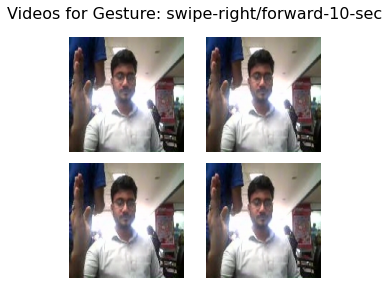

Video 1 for Gesture: swipe-left/backward-10-sec: Predicted Gesture: swipe-left/backward-10-sec, Confidence: 0.99


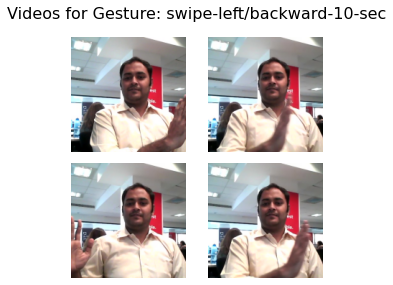

Video 2 for Gesture: Palm/pause: Predicted Gesture: Palm/pause, Confidence: 1.00


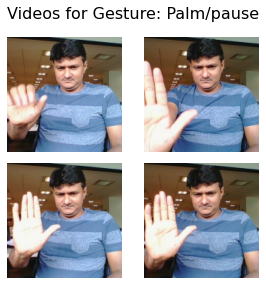

Video 3 for Gesture: Thumbs-down/lower-the-volume: Predicted Gesture: Thumbs-down/lower-the-volume, Confidence: 1.00


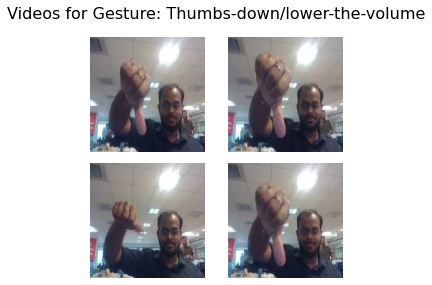

Video 4 for Gesture: thumbs-up/Higher-the-volume: Predicted Gesture: thumbs-up/Higher-the-volume, Confidence: 0.99


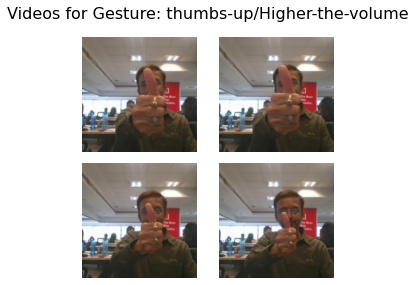

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary mapping class indices to gesture names
class_mapping = {
    0: "swipe-right/forward-10-sec",
    1: "swipe-left/backward-10-sec",
    2: "Palm/pause",
    3: "Thumbs-down/lower-the-volume",
    4: "thumbs-up/Higher-the-volume",
}

# Grid settings
grid_columns, grid_rows = 2, 2
videos_per_class = {i: [] for i in range(len(class_mapping))}

# Group videos by their true labels
for i in range(batch_data.shape[0]):
    video = batch_data[i]
    true_label_index = np.argmax(batch_labels[i])  # Ground truth label index
    videos_per_class[true_label_index].append(video)

# Plot a grid of videos per class and make predictions
for class_idx, videos in videos_per_class.items():
    gesture_name = class_mapping.get(class_idx, "Unknown Gesture")
    
    # Create the figure for the grid of videos
    plt.figure(figsize=(4, 4))
    plt.suptitle(f"Videos for Gesture: {gesture_name}", fontsize=16)

    # Plot videos and frames for the current class
    for idx, video in enumerate(videos[:grid_columns * grid_rows]):  # Limit to grid size
        for frame_idx, frame in enumerate(video[:grid_columns * grid_rows]):
            plot_position = idx * grid_columns * grid_rows + frame_idx + 1
            if plot_position <= grid_rows * grid_columns:
                plt.subplot(grid_rows, grid_columns, plot_position)
                plt.imshow((frame * 255).astype('uint8'))  # Rescale to [0, 255]
                plt.axis('off')

        # Get model prediction for the current video
                prediction = model6.predict(np.expand_dims(video, axis=0))  # Predict for the current video
                predicted_class = np.argmax(prediction, axis=1)[0]
                confidence = prediction[0][predicted_class]  # Get the confidence for the prediction

        # Print the predicted class name for the video
    predicted_label_name = class_mapping.get(predicted_class, "Unknown Gesture")  # Predicted class name
    print(f"Video {class_idx } for Gesture: {gesture_name}: Predicted Gesture: {predicted_label_name}, Confidence: {confidence:.2f}")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_204/3677531917.py:31: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(video_indices, predicted_labels_numeric, c='red', label='Predicted Labels', alpha=0.7, marker='x', edgecolors='w', s=200)


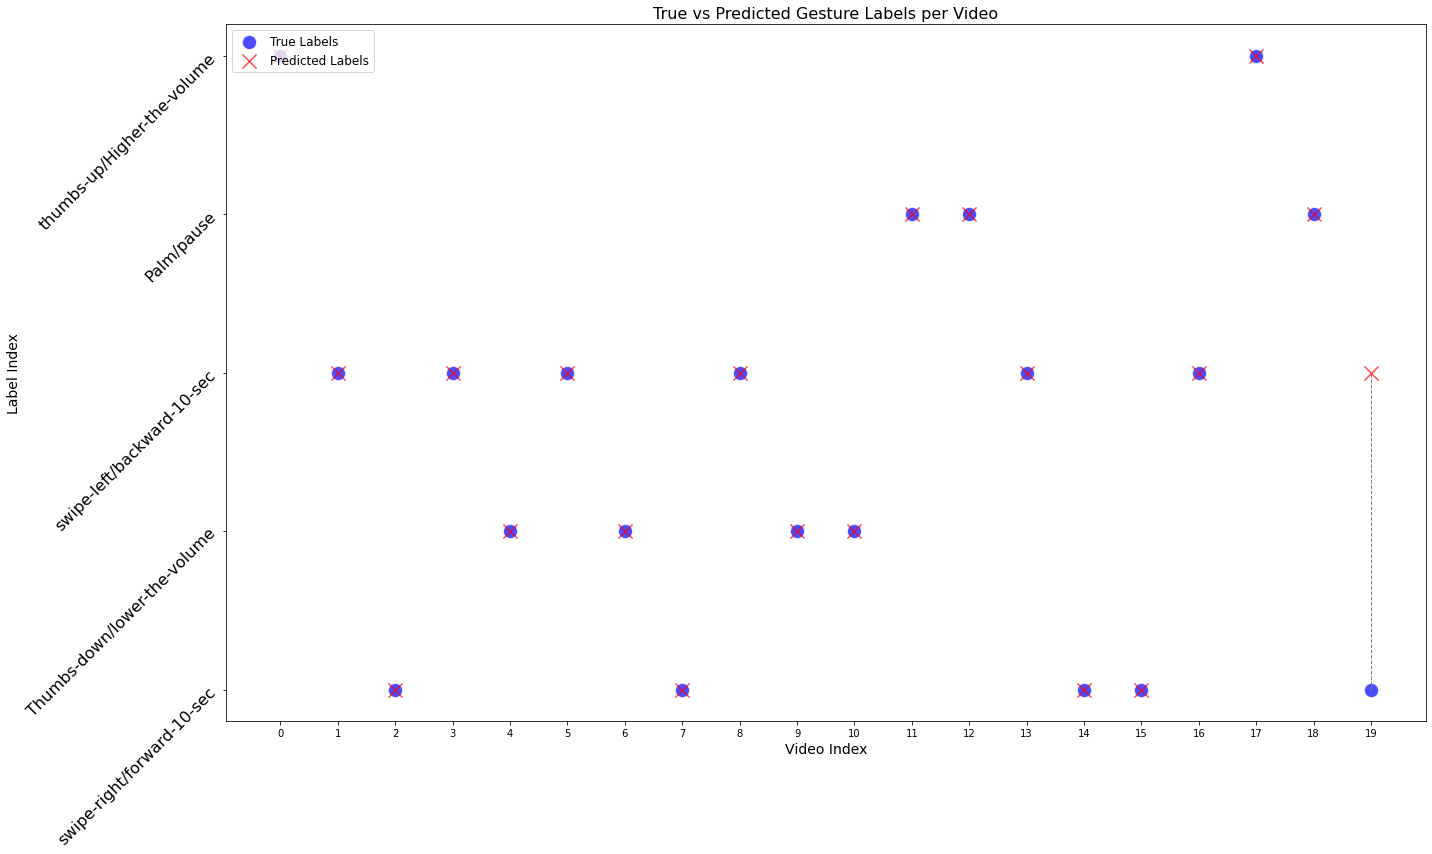

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary mapping class indices to gesture names
class_mapping = {
    0: "swipe-right/forward-10-sec", 1: "swipe-left/backward-10-sec", 
    2: "Palm/pause", 3: "Thumbs-down/lower-the-volume", 4: "thumbs-up/Higher-the-volume",
}

# Initialize lists for statistics
true_labels_list, predicted_labels_list, video_indices = [], [], []

# Iterate through each video in the batch and collect stats
for i, (video, label) in enumerate(zip(batch_data, batch_labels)):
    true_label_name = class_mapping.get(np.argmax(label), "Unknown Gesture")
    predicted_label_name = class_mapping.get(np.argmax(model6.predict(np.expand_dims(video, axis=0))), "Unknown Gesture")
    true_labels_list.append(true_label_name)
    predicted_labels_list.append(predicted_label_name)
    video_indices.append(i)

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Generate a numeric mapping for labels
label_to_numeric = {label: idx for idx, label in enumerate(set(true_labels_list + predicted_labels_list))}
true_labels_numeric = [label_to_numeric[label] for label in true_labels_list]
predicted_labels_numeric = [label_to_numeric[label] for label in predicted_labels_list]

# Plot true and predicted labels with connecting lines
ax.scatter(video_indices, true_labels_numeric, c='blue', label='True Labels', alpha=0.7, marker='o', edgecolors='w', s=200)
ax.scatter(video_indices, predicted_labels_numeric, c='red', label='Predicted Labels', alpha=0.7, marker='x', edgecolors='w', s=200)

# Add lines connecting true and predicted labels
for i in video_indices:
    ax.plot([i, i], [true_labels_numeric[i], predicted_labels_numeric[i]], 'gray', linestyle='--', linewidth=1)

# Set plot labels and titles
ax.set_xlabel('Video Index', fontsize=14)
ax.set_ylabel('Label Index', fontsize=14)
ax.set_title('True vs Predicted Gesture Labels per Video', fontsize=16)
ax.set_xticks(video_indices)
ax.set_yticks(range(len(label_to_numeric)))
ax.set_yticklabels(list(label_to_numeric.keys()), fontsize=16, rotation=45)

# Add legend and improve layout
ax.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()